In [1]:
!nvidia-smi

Wed May  1 20:19:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

# Change Directory

In [0]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/fcn_pytorch") # to project dir
print(os.getcwd())
!ls

# Import

In [0]:
import os
import re
import time
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch.optim as optim

# Setting Directory

In [0]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

train_data_dir = "../datasets/voc_semseg/train"
val_data_dir = "../datasets/voc_semseg/val"

train_img_dir = os.path.join(train_data_dir, 'img')
train_gt_dir = os.path.join(train_data_dir, 'gt')
val_img_dir = os.path.join(val_data_dir, 'img')
val_gt_dir = os.path.join(val_data_dir, 'gt')

# Utility Functions

In [0]:
def key_sort_by_num(x):
    re_list = re.findall(r"[0-9]+", x)
    re_list = list(map(int, re_list))
    return re_list


def list_from_dir(dir, target_ext=None):
    img_list = []
    fnames = os.listdir(dir)
    fnames = sorted(fnames, key=key_sort_by_num)
    for fname in fnames:
        if target_ext is None:
            path = os.path.join(dir, fname)
            img_list.append(path)
        else:
            _, ext = os.path.splitext(fname)
            if ext.lower() in target_ext:
                path = os.path.join(dir, fname)
                img_list.append(path)
    return img_list

In [0]:
#train_data_paths = list_from_dir(train_img_dir, ('.jpg', '.png'))
#train_gt_paths = list_from_dir(train_gt_dir, ('.jpg', '.png'))
#val_data_paths = list_from_dir(val_img_dir, ('.jpg', '.png'))
#val_gt_paths = list_from_dir(val_gt_dir, ('.jpg', '.png'))

#print(len(train_data_paths))
#print(len(train_gt_paths))
#print(len(val_data_paths))
#print(len(val_gt_paths))

In [0]:
def make_cmap():
    ctbl = ((0x80, 0, 0), (0, 0x80, 0), (0, 0, 0x80),
            (0x40, 0, 0), (0, 0x40, 0), (0, 0, 0x40),
            (0x20, 0, 0), (0, 0x20, 0))

    n = 256
    lookup = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        r, g, b = 0, 0, 0
        for j in range(0, 7):
            bit = (i >> j) & 1
            if bit:
                r |= ctbl[j][0]
                g |= ctbl[j][1]
                b |= ctbl[j][2]

        lookup[i, 0], lookup[i, 1], lookup[i, 2] = r, g, b
    return lookup[0:21]

In [0]:
def pil_to_tensor(pil_img):
    """ Convert from PIL to tensor
     # Arguments
            pil_img: array, 3 dimention(H x W x C)
    """
    img = np.array(pil_img, copy=False)
    img = img.transpose((2, 0, 1)) # H x W x C -> C x H x W
    img = img.astype(np.float32) # uint8 -> float32
    img = torch.from_numpy(img) # ndarray -> tensor
    img.div_(255)
    return img


def tensor_to_pil(tesnor_img):
    """ Convert from Tensor to PIL
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return Image.fromarray(img)


def tensor_to_ndarray(tesnor_img):
    """ Convert from Tensor to ndarray
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return img



def pil_to_one_hot_array(label_array, classes, size):
    """ Convert from PIL to one-hot-array
     # Arguments
            label_array: array, 3 dimention(H x W x C)
            classes: int, num of class
            size: int, image shape
    """
    x = np.zeros((classes, size, size)) # C x H x W
    for i in range(size):
        for j in range(size):
            x[label_array[i][j], i, j] = 1
    return x


def pred_to_pil(pred):
    """ Convert from one-hot-array to PIL
     # Arguments
            pred: tensor, 3 dimention(C x H x W)
    """
    cmap = make_cmap()
    
    pred_ = pred.numpy() # tensor -> ndarray
    channel, _, _ = pred_.shape
    pred_ = pred_.transpose(1, 2, 0) # C x H x W -> H x W x C
    pred_ = np.argmax(pred_, axis=2) #  H x W x C -> H x W
    
    row, col = pred_.shape
    dst = np.ones((row, col, 3))
    
    for i in range(channel):
        dst[pred_ == i] = cmap[i]

    dst = dst.astype(np.uint8)
    return  Image.fromarray(dst) # ndarray -> PIL

In [0]:
def show_imgs(imgs, size,  figsize=[6.4, 4.8], converter=False):
    """Show images
     # Arguments
            imgs: 1-D array, 4 dimention(batch x H x W x C)
            row: Int, row for plt.subplot
            col: Int, column for plt.subplot
    """
    row, col = size
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

  
    plt.figure(figsize=figsize)
    plt.tight_layout()

    for i, img in enumerate(imgs):
        if converter:
            img = converter(img)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Create Dataset and DataLoader

In [0]:
class SemSegDataset(Dataset):
    
    def __init__(self, classes, input_size, img_dir, target_dir=None, train=False):
        self.classes = classes
        self.input_size = input_size
        
        self.img_paths = list_from_dir(img_dir, ('.jpg', '.png'))
        if target_dir:
            self.target_paths = list_from_dir(target_dir, ('.jpg', '.png'))
        else:
            self.target_paths = None
            
        self.train = train
        
        self.eval_trns = transforms.Compose([
            transforms.CenterCrop(self.input_size)
        ])

        # check data num
        img_num = len(self.img_paths)
        if target_dir:
            target_num = len(self.target_paths)
            assert img_num == target_num, "img/gt not equal, img:{} gt:{}".format(img_num, target_num)
        
        self.data_num = img_num

        
    def __len__(self):
        return self.data_num
    
    
    def _transform(self, img, target, train):
        
        if train:
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=self.input_size)
            img = TF.crop(img, i, j, h, w)
            if target:
                target = TF.crop(target, i, j, h, w)
      
            if random.random() < 0.5:
                image = TF.hflip(image)
                if target:
                    target = TF.hflip(target)
            
        else:
            img = self.eval_trns(img)
            if target:
                target = self.eval_trns(target)
     
        img = pil_to_tensor(img) # 0-255 -> 0-1
        
        if target:
            target = np.asarray(target, dtype=np.int32)
            target[target == 255] = 0  # 境界部分をbackgroundクラスにする
            target = pil_to_one_hot_array(target, self.classes, self.input_size)
            target = torch.from_numpy(target).long() # ラベルをtensor型に変換
        
        return img, target

    def __getitem__(self, idx):
        assert idx < self.data_num,"invalid idx {}, max idx is {}".format(idx, self.data_num-1)
        
        img = Image.open(self.img_paths[idx])
        if self.target_paths:
            target = Image.open(self.target_paths[idx])
        else:
            target = None
        
        x, y = self._transform(img, target, self.train)

        return x, y

In [0]:
train_dataset = SemSegDataset(21, 224, train_img_dir, train_gt_dir)
val_dataset    = SemSegDataset(21, 224, val_img_dir, val_gt_dir)

In [0]:
x,y = train_dataset[0]

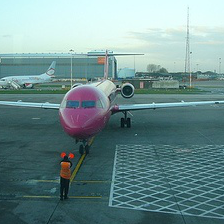

In [14]:
tensor_to_pil(x)

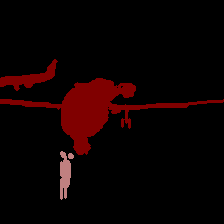

In [15]:
pred_to_pil(y)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_dataloader    = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=4)

torch.Size([24, 3, 224, 224])
torch.Size([24, 21, 224, 224])


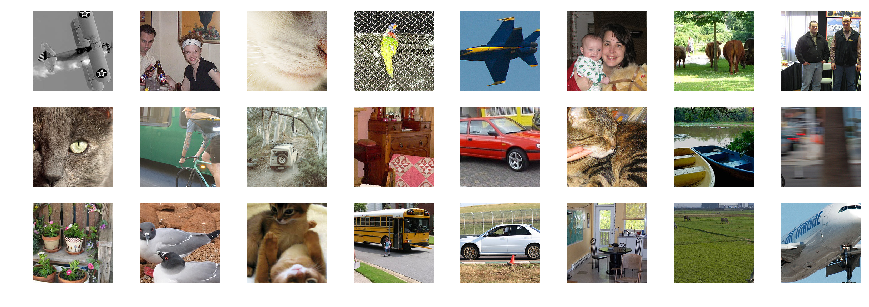

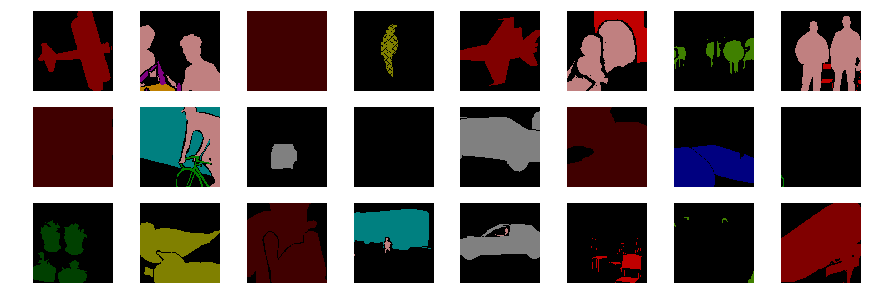

In [17]:
for d in train_dataloader:
    print(d[0].shape)
    print(d[1].shape)
    break
    
            
show_imgs(d[0], [3, 8], figsize=(15,5), converter=tensor_to_ndarray)
show_imgs(d[1], [3, 8], figsize=(15,5), converter=pred_to_pil)

# Define Model

In [0]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/models/fcn32s.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """
    Make a 2D bilinear kernel suitable for upsampling
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt

    return torch.from_numpy(weight).float()

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock

class EncorderResNet(ResNet):
    
    def __init__(self, layers=[2, 2, 2, 2]):
        super().__init__(BasicBlock, layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x3 = x
        x = self.layer3(x)
        x4 = x
        x = self.layer4(x)
        x5 = x
        
        return x3, x4, x5

In [0]:
class FCN32s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
        
        self.relu = nn.ReLU(inplace=True)
        
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=64, stride=32, padding=16,
                                                                       bias=False)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
                
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
               
        x = self.score5(x5)
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN16s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
           
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)
 
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=16, stride=8, padding=4,
                                                                       bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
    
    
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x4 = self.score4(x4)
        x5 = self.score5(x5)
        
        x4 = self.upscore4(x4)
        x5 = self.upscore5(x5)
        
        x = x4 + x5
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN8s(nn.Module):
    
    def __init__(self, num_classes, encorder, bilinear=False):
        super().__init__()
        
        self.bilinear = bilinear
        
        self.encorder = encorder
           
        self.score3 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)

        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)

        if not self.bilinear:
            self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                           kernel_size=16, stride=8, padding=4,
                                                                           bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
        
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x3 = self.score3(x3)
        x4 = self.score4(x4)
        x5 = self.score5(x5)     

        x4 = self.upscore4(x4) # x2
        x5 = self.upscore5(x5) # x4
        
        x = x3 + x4 + x5
        
        if self.bilinear:
            x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
        else:
            x = self.upscore(x) # x8
        
        return x

In [0]:
from torchvision.models import resnet18
def build_encorder():
    encorder = EncorderResNet(layers=[2, 2, 2, 2])
    encorder.load_state_dict(resnet18(pretrained=True).state_dict())
    return encorder

# Create Model

In [24]:
encorder = build_encorder()
model = FCN8s(num_classes=21, encorder=encorder)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 89581246.82it/s]


In [25]:
from torchsummary import summary
summary(model,  input_size=(3, 224, 224),   device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Define Trainer

In [26]:
# pip install tqdm
pip install fastprogress

In [0]:
# from tqdm import tqdm_notebook as tqdm
from fastprogress import master_bar, progress_bar
import copy
import time


def calc_acc(preds, labels):
    correct = (preds == labels).sum()
    total     = (labels == labels).sum()
    correct = correct.to(torch.float32)
    total     = total.to(torch.float32)
    return (correct / total)


class Trainer:
    
    def __init__(self, model, device, optimizer, criterion, train_loader, val_loader=None,
                          scheduler=None, history=None, prev_epochs=0):

        self.print_state = True
        
        self.done_epochs = prev_epochs # 0-
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.scheduler = scheduler
        
        self.best_val_acc = 0.0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        
        if history:
            self.history = history
        else:
            self.history = {'epoch':[], 'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
        
        self.train_loader = train_loader
        self.train_data_num = len(self.train_loader.dataset)
        self.train_sptes_per_epoch = len(self.train_loader)
        
        self.val_loader = val_loader
        if self.val_loader:
            self.val_data_num = len(self.val_loader.dataset)
            self.val_sptes_per_epoch = len(self.val_loader)
        else:
            self.val_data_num = 0
            self.val_sptes_per_epoch = 0

        self.model.to(self.device)
        
        
    def set_print_state(self, state=True):
        self.print_state = state
        
        
    def train_loop(self, epochs):
        total_epochs = self.done_epochs + epochs

        #------------------------------------------------------------------------
        # pre print
        #------------------------------------------------------------------------        
        if self.print_state:
            print("Device :  ", self.device)
            print("Train on {} samples, validate on {} samples".format(self.train_data_num,
                                                                                                                 self.val_data_num))
            for i in range(self.done_epochs):
                done_history_idx = i
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))

        #------------------------------------------------------------------------
        # training loop
        #------------------------------------------------------------------------
        for _ in range(epochs):
            self.history['epoch'].append(self.done_epochs+1) # 1-
            
            start_time = time.time()            
            train_score = self._train_one_epoch()
            end_time = time.time()
            
            self.history['train_acc'].append(train_score['acc'])
            self.history['train_loss'].append(train_score['loss'])
            
            if self.val_loader:
                val_score = self._val_one_epoch()
                self.history['val_acc'].append(val_score['acc'])
                self.history['val_loss'].append(val_score['loss'])
                
                if self.best_val_acc < val_score['acc']:
                    self.best_val_acc = val_score['acc']
                    self.best_model_wts = copy.deepcopy(model.state_dict())
                
                if self.scheduler:
                    self.scheduler.step(val_score['loss'])
                    
            else:
                if self.scheduler:
                    self.scheduler.step(train_score['loss'])
                

            self.done_epochs += 1

            #------------------------------------------------------------------------
            # post print
            #------------------------------------------------------------------------
            if self.print_state:
                elapsed_time = end_time-start_time
                done_history_idx = self.done_epochs-1
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))

                    
    def _one_step(self, data, labels, train=True):
            if train:
                self.optimizer.zero_grad()
            
            outputs = self.model(data)
            
            # (batchsize x C x H x W) -> (bachsize x H x W)
            labels = torch.argmax(labels, dim=1, keepdim=False)
            preds = torch.argmax(outputs, dim=1, keepdim=False)
            
            loss = self.criterion(outputs, labels)
            
            if train:
                loss.backward()
                self.optimizer.step()
            
            correct = calc_acc(preds, labels)

            return loss.item(), correct.item()

        
    def _train_one_epoch(self):
        self.model.train()
        
        running_loss = 0
        running_correct = 0

        #for batch_idx, (data, labels) in enumerate(self.train_loader):
        #for batch_idx, (data, labels) in tqdm(enumerate(self.train_loader)):
        for batch_idx, (data, labels) in enumerate(progress_bar(self.train_loader)): # naka
            data, labels = data.to(self.device), labels.to(self.device)
            
            loss, correct = self._one_step(data, labels, train=True)
    
            running_loss       += loss
            running_correct += correct

        train_loss = running_loss      / self.train_sptes_per_epoch
        train_acc = running_correct / self.train_sptes_per_epoch
        
        return {'loss':train_loss, 'acc':train_acc}

    
    def _val_one_epoch(self):
        self.model.eval()
        
        running_loss = 0
        running_correct = 0

        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                loss, correct = self._one_step(data, labels, train=False)

                running_loss       += loss
                running_correct += correct
                
        val_loss = running_loss      / self.val_sptes_per_epoch
        val_acc = running_correct / self.val_sptes_per_epoch

        return {'loss':val_loss, 'acc':val_acc}

    
    def save_best_model(self, path):
        torch.save(self.best_model_wts, path)
    

    def save_checkpoint(self, path):
        ckpt = {
            'model_satate_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict(),
            'history':self.history
        }
        torch.save(ckpt, path)

# Start Training

In [28]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                                                                            patience=6,  verbose=True) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader,scheduler=exp_lr_scheduler)

cuda:0


In [29]:
trainer.train_loop(15)

Device :   cuda:0
Train on 1464 samples, validate on 1449 samples


Epoch:1/15 train_acc:0.6826% train_loss:1.2146 val_acc:0.7409% val_loss:0.8308 time:233.007


Epoch:2/15 train_acc:0.8219% train_loss:0.5613 val_acc:0.7725% val_loss:0.7306 time:55.084


Epoch:3/15 train_acc:0.8687% train_loss:0.3962 val_acc:0.7801% val_loss:0.7271 time:54.901


Epoch:4/15 train_acc:0.8959% train_loss:0.3068 val_acc:0.7840% val_loss:0.7357 time:53.572


Epoch:5/15 train_acc:0.9103% train_loss:0.2604 val_acc:0.7954% val_loss:0.6903 time:55.195


Epoch:6/15 train_acc:0.9196% train_loss:0.2315 val_acc:0.7967% val_loss:0.6899 time:54.342


Epoch:7/15 train_acc:0.9238% train_loss:0.2169 val_acc:0.7909% val_loss:0.7262 time:53.603


Epoch:8/15 train_acc:0.9288% train_loss:0.1982 val_acc:0.7976% val_loss:0.7195 time:54.409


Epoch:9/15 train_acc:0.9324% train_loss:0.1884 val_acc:0.7965% val_loss:0.7425 time:54.670


Epoch:10/15 train_acc:0.9353% train_loss:0.1784 val_acc:0.7965% val_loss:0.7283 time:53.480


Epoch:11/15 train_acc:0.9394% train_loss:0.1665 val_acc:0.8013% val_loss:0.7259 time:55.475


Epoch:12/15 train_acc:0.9406% train_loss:0.1623 val_acc:0.8001% val_loss:0.7278 time:54.453


Epoch    12: reducing learning rate of group 0 to 1.0000e-03.
Epoch:13/15 train_acc:0.9385% train_loss:0.1657 val_acc:0.7963% val_loss:0.7498 time:53.402


Epoch:14/15 train_acc:0.9433% train_loss:0.1543 val_acc:0.8003% val_loss:0.7440 time:55.032


Epoch:15/15 train_acc:0.9453% train_loss:0.1485 val_acc:0.7995% val_loss:0.7391 time:54.839


In [0]:
# trainer.save_checkpoint('checkpoint_fcn8s.tar')
# trainer.save_best_model('fcn8s.pt')

# Plot acc and loss curve

In [0]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

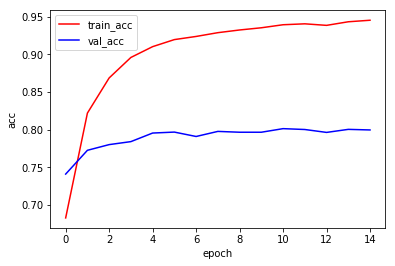

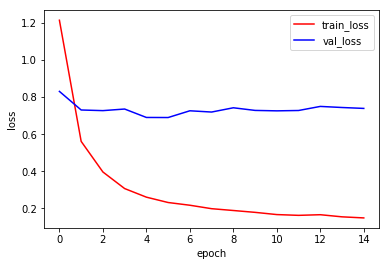

In [31]:
plot_history(trainer.history)

# Evaluate

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('fcn8s.pt', map_location=device))

In [0]:
 classnames=[
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boad",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motor_bike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv"]

In [0]:
def evaluate(model, device, criterion, test_loader):
    model.eval()
    runnning_loss = 0
    running_correct = 0
    with torch.no_grad():
        for data in progress_bar(test_loader):
            imgs, labels = data            
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            labels = torch.argmax(labels, dim=1, keepdim=False)
            pred = torch.argmax(outputs, dim=1, keepdim=False)
            runnning_loss += criterion(outputs, labels).item()
            running_correct += calc_acc(pred, labels)
            
    test_acc = running_correct / len(test_loader)
    test_loss = runnning_loss / len(test_loader)

    return {'loss':test_loss, 'acc':test_acc}

In [35]:
test_loader = val_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
test_score = evaluate(model, device, criterion, test_loader)

device: cuda


In [36]:
print('acc  : {:.4f}'.format(test_score['acc']))
print('loss : {:.4f}'.format(test_score['loss']) )

acc  : 0.8035
loss : 0.7249


# Predict

In [0]:
def predict(model, device, imgs):
    model.eval()
    
    if len(imgs.size()) != 4:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = model(imgs)
        
    return output

In [0]:
device = 'cpu'
img, label = val_dataset[11]
model.to(device)
out = predict(model, device, img)

label_pil = pred_to_pil(label)
out_pil = pred_to_pil(out[0])
input_pil = tensor_to_pil(img)

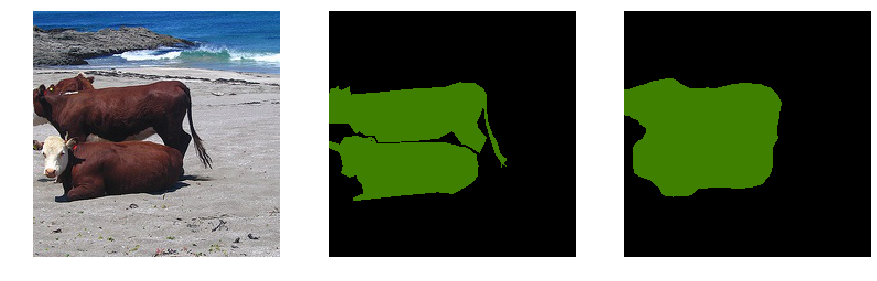

In [39]:
show_imgs([input_pil, label_pil, out_pil], [1, 3], figsize=(15,5))

# Save as ONNX

In [0]:
# pip install torchvision==0.2.1
import torch
dummy_input = torch.randn(1, 3, 224, 224,)
torch_out = torch.onnx.export(model, dummy_input, "fcn8s.onnx", verbose=True)

# Optuna

In [36]:
!pip install optuna

In [0]:
import optuna

In [0]:
import torch.optim as optim

def create_optimizer(trial, model):
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    optimizer_name = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])
    if optimizer_name == 'MomentumSGD':
        lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('invalid name:', optimizer_name)

    return optimizer


def create_activation(trial):
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'ELU'])
    
    if  activation_name == 'ReLU':
        activation = F.relu
    elif activation_name =='ELU':
        activation = F.elu
    else:
        raise ValueError('invalid name:', activation_name)
    
    return activation


def create_dropoutrate(trial):
    return trial.suggest_uniform('dropout_prob', 0, 0.8)


def is_bilinear(trial):
    upsampling = trial.suggest_categorical('upsampling', ['ConvTranspose2d', 'bilinear'])
    if upsampling == 'bilinear':
        bilinear = True
    else:
        bilinear = False
    return bilinear

In [0]:
def objective(trial):
    EPOCH = 1
    
    encorder = build_encorder()
    model = FCN8s(num_classes=21, encorder=encorder, bilinear=is_bilinear(trial))
    
    optimizer = create_optimizer(trial, model)

        
    #-----------------------------------------
    # build model
    #-----------------------------------------
    criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader)

    #-----------------------------------------
    # start training
    #-----------------------------------------
    trainer.train_loop(EPOCH)

    #-----------------------------------------
    # get validation loss
    #-----------------------------------------
    last_val_loss = trainer.history['val_loss'][-1]

    return last_val_loss

In [50]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4815% train_loss:2.2879 val_acc:0.5958% val_loss:1.7501 time:53.783


[I 2019-05-01 12:00:15,240] Finished trial#0 resulted in value: 1.7501265689974925. Current best value is 1.7501265689974925 with parameters: {'upsampling': 'bilinear', 'weight_decay': 2.052053557075739e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.00023103649041159198}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.2726% train_loss:2.7175 val_acc:0.4318% val_loss:2.5396 time:55.463


[I 2019-05-01 12:02:04,830] Finished trial#1 resulted in value: 2.5395641405074323. Current best value is 1.7501265689974925 with parameters: {'upsampling': 'bilinear', 'weight_decay': 2.052053557075739e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.00023103649041159198}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6712% train_loss:1.2837 val_acc:0.7390% val_loss:0.8516 time:56.843


[I 2019-05-01 12:03:55,987] Finished trial#2 resulted in value: 0.8515639363742266. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5560% train_loss:1.9609 val_acc:0.5090% val_loss:2.2190 time:53.975


[I 2019-05-01 12:05:44,441] Finished trial#3 resulted in value: 2.2190172691814234. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3888% train_loss:2.4558 val_acc:0.6299% val_loss:1.7704 time:55.705


[I 2019-05-01 12:07:34,416] Finished trial#4 resulted in value: 1.7703688027428799. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5700% train_loss:1.8494 val_acc:0.6780% val_loss:1.2569 time:56.210


[I 2019-05-01 12:09:25,168] Finished trial#5 resulted in value: 1.2569034431801467. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3471% train_loss:2.7387 val_acc:0.5485% val_loss:2.3852 time:54.608


[I 2019-05-01 12:11:13,549] Finished trial#6 resulted in value: 2.3852130545944465. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6173% train_loss:1.5764 val_acc:0.7512% val_loss:0.9332 time:55.609


[I 2019-05-01 12:13:04,903] Finished trial#7 resulted in value: 0.9332099263785315. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5512% train_loss:2.0635 val_acc:0.5247% val_loss:2.2649 time:54.891


[I 2019-05-01 12:14:54,461] Finished trial#8 resulted in value: 2.2648844484423027. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.0850% train_loss:3.2027 val_acc:0.2385% val_loss:2.7809 time:55.785


[I 2019-05-01 12:16:42,829] Finished trial#9 resulted in value: 2.7809313711572865. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3758% train_loss:2.6688 val_acc:0.5317% val_loss:2.4336 time:57.048


[I 2019-05-01 12:18:34,773] Finished trial#10 resulted in value: 2.4335713386535645. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5814% train_loss:1.6408 val_acc:0.5753% val_loss:1.4839 time:54.056


[I 2019-05-01 12:20:23,027] Finished trial#11 resulted in value: 1.4838995855362689. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3772% train_loss:2.7129 val_acc:0.5534% val_loss:2.2582 time:55.660


[I 2019-05-01 12:22:11,291] Finished trial#12 resulted in value: 2.258248403424122. Current best value is 0.8515639363742266 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 2.862455182604367e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.011148023492251056}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6653% train_loss:1.3123 val_acc:0.7460% val_loss:0.8231 time:56.948


[I 2019-05-01 12:24:03,147] Finished trial#13 resulted in value: 0.8230959255187238. Current best value is 0.8230959255187238 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 1.1876905666286311e-10, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.004733360246084806}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6764% train_loss:1.2578 val_acc:0.7576% val_loss:0.8017 time:53.901


[I 2019-05-01 12:25:51,299] Finished trial#14 resulted in value: 0.8017291250776072. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5487% train_loss:2.1981 val_acc:0.5596% val_loss:1.8890 time:55.696


[I 2019-05-01 12:27:39,445] Finished trial#15 resulted in value: 1.888980417955117. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4548% train_loss:5.4846 val_acc:0.5051% val_loss:9.1019 time:56.610


[I 2019-05-01 12:29:30,191] Finished trial#16 resulted in value: 9.101877447034491. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6424% train_loss:1.4678 val_acc:0.7519% val_loss:0.8500 time:54.308


[I 2019-05-01 12:31:18,217] Finished trial#17 resulted in value: 0.8500160653083051. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6502% train_loss:1.3561 val_acc:0.6477% val_loss:1.1985 time:55.647


[I 2019-05-01 12:33:07,430] Finished trial#18 resulted in value: 1.198489851638919. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5816% train_loss:1.8022 val_acc:0.6709% val_loss:1.2387 time:54.979


[I 2019-05-01 12:34:56,776] Finished trial#19 resulted in value: 1.2386686029981395. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6503% train_loss:1.4365 val_acc:0.7292% val_loss:0.9135 time:55.415


[I 2019-05-01 12:36:44,828] Finished trial#20 resulted in value: 0.9134802261336905. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5206% train_loss:2.1727 val_acc:0.5856% val_loss:1.7047 time:55.629


[I 2019-05-01 12:38:36,416] Finished trial#21 resulted in value: 1.704693290053821. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6765% train_loss:1.2711 val_acc:0.7485% val_loss:0.8113 time:53.598


[I 2019-05-01 12:40:24,433] Finished trial#22 resulted in value: 0.8112779161969169. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6674% train_loss:1.2534 val_acc:0.7246% val_loss:0.9314 time:55.558


[I 2019-05-01 12:42:12,358] Finished trial#23 resulted in value: 0.9313858229605878. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5319% train_loss:2.5206 val_acc:0.5169% val_loss:2.1319 time:55.564


[I 2019-05-01 12:44:04,074] Finished trial#24 resulted in value: 2.131856189399469. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6731% train_loss:1.1898 val_acc:0.7412% val_loss:0.8262 time:53.800


[I 2019-05-01 12:45:52,306] Finished trial#25 resulted in value: 0.8262456948639917. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6132% train_loss:1.6226 val_acc:0.7277% val_loss:1.0007 time:55.627


[I 2019-05-01 12:47:40,581] Finished trial#26 resulted in value: 1.0007084490822964. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6805% train_loss:1.2078 val_acc:0.7230% val_loss:0.9230 time:56.799


[I 2019-05-01 12:49:32,469] Finished trial#27 resulted in value: 0.9229662457450492. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6464% train_loss:1.3562 val_acc:0.6157% val_loss:1.2680 time:53.869


[I 2019-05-01 12:51:20,546] Finished trial#28 resulted in value: 1.2680354040177142. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3968% train_loss:2.4510 val_acc:0.6530% val_loss:1.6674 time:55.692


[I 2019-05-01 12:53:08,976] Finished trial#29 resulted in value: 1.6674019254621912. Current best value is 0.8017291250776072 with parameters: {'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}.


In [53]:
print(study.best_value)
print(study.best_params)

0.8017291250776072
{'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}


In [52]:
study.best_trial

FrozenTrial(number=14, state=<TrialState.COMPLETE: 1>, value=0.8017291250776072, datetime_start=datetime.datetime(2019, 5, 1, 12, 24, 3, 155363), datetime_complete=datetime.datetime(2019, 5, 1, 12, 25, 51, 296724), params={'upsampling': 'ConvTranspose2d', 'weight_decay': 4.1736287719302397e-08, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.006197790848929989}, user_attrs={}, system_attrs={'_number': 14}, intermediate_values={}, params_in_internal_repr={'upsampling': 0, 'weight_decay': 4.1736287719302397e-08, 'optimizer': 0, 'momentum_sgd_lr': 0.006197790848929989}, trial_id=14)

In [55]:
study.trials_dataframe()

number                state     value             datetime_start  \
                                                                      
0       0  TrialState.COMPLETE  1.750127 2019-05-01 11:58:27.025682   
1       1  TrialState.COMPLETE  2.539564 2019-05-01 12:00:15.246173   
2       2  TrialState.COMPLETE  0.851564 2019-05-01 12:02:04.836860   
3       3  TrialState.COMPLETE  2.219017 2019-05-01 12:03:55.994203   
4       4  TrialState.COMPLETE  1.770369 2019-05-01 12:05:44.448313   
5       5  TrialState.COMPLETE  1.256903 2019-05-01 12:07:34.423062   
6       6  TrialState.COMPLETE  2.385213 2019-05-01 12:09:25.175350   
7       7  TrialState.COMPLETE  0.933210 2019-05-01 12:11:13.553291   
8       8  TrialState.COMPLETE  2.264884 2019-05-01 12:13:04.910667   
9       9  TrialState.COMPLETE  2.780931 2019-05-01 12:14:54.468510   
10     10  TrialState.COMPLETE  2.433571 2019-05-01 12:16:42.836987   
11     11  TrialState.COMPLETE  1.483900 2019-05-01 12:18:34.782666   
12     12  TrialState.COMPLETE  2.258248 2019-05-01 12:20:23.032919   
13     13  TrialState.COMPLETE  0.823096 2019-05-01 12:22:11.298383   
14     14  TrialState.COMPLETE  0.801729 2019-05-01 12:24:03.155363   
15     15  TrialState.COMPLETE  1.888980 2019-05-01 12:25:51.305403   
16     16  TrialState.COMPLETE  9.101877 2019-05-01 12:27:39.451504   
17     17  TrialState.COMPLETE  0.850016 2019-05-01 12:29:30.193656   
18     18  TrialState.COMPLETE  1.198490 2019-05-01 12:31:18.223802   
19     19  TrialState.COMPLETE  1.238669 2019-05-01 12:33:07.435440   
20     20  TrialState.COMPLETE  0.913480 2019-05-01 12:34:56.781860   
21     21  TrialState.COMPLETE  1.704693 2019-05-01 12:36:44.839512   
22     22  TrialState.COMPLETE  0.811278 2019-05-01 12:38:36.424079   
23     23  TrialState.COMPLETE  0.931386 2019-05-01 12:40:24.436419   
24     24  TrialState.COMPLETE  2.131856 2019-05-01 12:42:12.364758   
25     25  TrialState.COMPLETE  0.826246 2019-05-01 12:44:04.077951   
26     26  TrialState.COMPLETE  1.000708 2019-05-01 12:45:52.311911   
27     27  TrialState.COMPLETE  0.922966 2019-05-01 12:47:40.588347   
28     28  TrialState.COMPLETE  1.268035 2019-05-01 12:49:32.476034   
29     29  TrialState.COMPLETE  1.667402 2019-05-01 12:51:20.553312   

            datetime_complete    params                               \
                                adam_lr momentum_sgd_lr    optimizer   
0  2019-05-01 12:00:15.240472       NaN        0.000231  MomentumSGD   
1  2019-05-01 12:02:04.829604       NaN        0.000020  MomentumSGD   
2  2019-05-01 12:03:55.986687       NaN        0.011148  MomentumSGD   
3  2019-05-01 12:05:44.441115       NaN        0.040559  MomentumSGD   
4  2019-05-01 12:07:34.415706  0.000022             NaN         Adam   
5  2019-05-01 12:09:25.167517       NaN        0.000831  MomentumSGD   
6  2019-05-01 12:11:13.548387       NaN        0.000070  MomentumSGD   
7  2019-05-01 12:13:04.902628  0.000087             NaN         Adam   
8  2019-05-01 12:14:54.460564  0.003534             NaN         Adam   
9  2019-05-01 12:16:42.827413       NaN        0.000020  MomentumSGD   
10 2019-05-01 12:18:34.772452       NaN        0.000050  MomentumSGD   
11 2019-05-01 12:20:23.026221  0.001478             NaN         Adam   
12 2019-05-01 12:22:11.290419       NaN        0.000098  MomentumSGD   
13 2019-05-01 12:24:03.146329       NaN        0.004733  MomentumSGD   
14 2019-05-01 12:25:51.296724       NaN        0.006198  MomentumSGD   
15 2019-05-01 12:27:39.444244  0.003569             NaN         Adam   
16 2019-05-01 12:29:30.189555       NaN        0.089479  MomentumSGD   
17 2019-05-01 12:31:18.215196       NaN        0.002701  MomentumSGD   
18 2019-05-01 12:33:07.427750       NaN        0.023156  MomentumSGD   
19 2019-05-01 12:34:56.774358       NaN        0.000847  MomentumSGD   
20 2019-05-01 12:36:44.826867       NaN        0.002951  MomentumSGD   
21 2019-05-01 12:38:36.414204       NaN        0.000312  MomentumSGD   
22